# Reinforcement Learning - Policy Gradient
If you want to test/submit your solution **restart the kernel, run all cells and submit the pg_autograde.py file into codegrade.**

In [21]:
# This cell imports %%execwritefile command (executes cell and writes it into file). 
from custommagics import CustomMagics
get_ipython().register_magics(CustomMagics)

In [22]:
%%execwritefile pg_autograde.py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

Overwriting pg_autograde.py


In [23]:
%matplotlib inline

import matplotlib.pyplot as plt
import sys

import gym
import time

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

---

## 3. Policy Gradient

### 3.1 Policy Network

In order to implement policy gradient, we will first implement a class with a policy network. Although in general this does not have to be the case, we will use an architecture very similar to the Q-network that we used (two layers with ReLU activation for the hidden layer). Since we have discrete actions, our model will output one value per action, where each value represents the (normalized!) probability of selecting that action. *Use the softmax activation function.*

In [24]:
class NNPolicy(nn.Module):
    
    def __init__(self, num_hidden=128):
        super(NNPolicy, self).__init__()
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)

    def forward(self, x):
        """
        Performs a forward pass through the network.
        
        Args:
            x: input tensor (first dimension is a batch dimension)
            
        Return:
            Probabilities of performing all actions in given input states x. Shape: batch_size x action_space_size
        """

        #apply RELU to hidden layer
        x = F.relu(self.l1(x))

        #pass to last layer
        x = self.l2(x)

        #apply Softmax activation
        x = F.softmax(x)

        return x
        
    def get_probs(self, obs, actions):
        """
        This function takes a tensor of states and a tensor of actions and returns a tensor that contains 
        a probability of performing the corresponding action in all states (one for every state-action pair). 

        Args:
            obs: a tensor of states. Shape: batch_size x obs_dim
            actions: a tensor of actions. Shape: batch_size x 1

        Returns:
            A torch tensor filled with probabilities. Shape: batch_size x 1.
        """

        #get the probabilities of actions for givens state
        action_probs = self.forward(torch.tensor(obs).float())
        actions = torch.tensor(action_probs, dtype=torch.int64)
        #select the probability of the chosen action
        selected_action_probs = action_probs.gather(0, actions)

        return selected_action_probs
    
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: state as a tensor. Shape: 1 x obs_dim or obs_dim

        Returns:
            An action (int).
        """
        with torch.no_grad():
            #get probabilities for current state
            action_probs = self.forward(obs)
            #sample an action given the probabilities
            action = torch.multinomial(action_probs, 1).item()
        
        return action
        
        

In [25]:
# Let's instantiate and test if it works
num_hidden = 128
torch.manual_seed(1234)
policy = NNPolicy(num_hidden)

states = torch.rand(10, 4)
actions = torch.randint(low=0, high=2, size=(10,1))
print(actions)

# Does the outcome make sense?
forward_probs = policy.forward(states)
print(forward_probs)
assert forward_probs.shape == (10,2), "Output of forward has incorrect shape."
sampled_action = policy.sample_action(states[0])
assert sampled_action == 0 or sampled_action == 1, "Output of sample action is not 0 or 1"

action_probs = policy.get_probs(states, actions)
print(action_probs)
assert action_probs.shape != (10,1), "Output of get_probs has incorrect shape."

tensor([[0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [0]])
tensor([[0.4578, 0.5422],
        [0.4657, 0.5343],
        [0.4563, 0.5437],
        [0.4634, 0.5366],
        [0.4564, 0.5436],
        [0.4725, 0.5275],
        [0.4769, 0.5231],
        [0.4834, 0.5166],
        [0.4797, 0.5203],
        [0.4618, 0.5382]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4578, 0.5422],
        [0.4578, 0.5422],
        [0.4578, 0.5422],
        [0.4578, 0.5422],
        [0.4578, 0.5422],
        [0.4578, 0.5422],
        [0.4578, 0.5422],
        [0.4578, 0.5422],
        [0.4578, 0.5422],
        [0.4578, 0.5422]], grad_fn=<GatherBackward0>)


c:\Users\Alvaro Millan Ruiz\Anaconda3.1\envs\rlcourse\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
c:\Users\Alvaro Millan Ruiz\Anaconda3.1\envs\rlcourse\lib\site-packages\ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\Alvaro Millan Ruiz\Anaconda3.1\envs\rlcourse\lib\site-packages\ipykernel_launcher.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


### 3.2 Monte Carlo REINFORCE

Now we will implement the *Monte Carlo* policy gradient algorithm. Remember that this means that we will estimate returns for states by sample episodes. Compared to DQN, this means that we do *not* perform an update step at every environment step, but only at the end of each episode. This means that we should generate an episode of data, compute the REINFORCE loss (which requires computing the returns) and then perform a gradient step.

* You can use `torch.multinomial` to sample from a categorical distribution.
* The REINFORCE loss is defined as $- \sum_t \log \pi_\theta(a_t|s_t) G_t$, which means that you should compute the (discounted) return $G_t$ for all $t$. Make sure that you do this in **linear time**, otherwise your algorithm will be very slow! Note the - (minus) since you want to maximize return while you want to minimize the loss.

To help you, we wrote down signatures of a few helper functions. Start by implementing a sampling routine that samples a single episode (similarly to the one in Monte Carlo lab).

In [26]:
def sample_episode(env, policy):
    """
    A sampling routine. Given environment and a policy samples one episode and returns states, actions, rewards
    and dones from environment's step function as tensors.

    Args:
        env: OpenAI gym environment.
        policy: A policy which allows us to sample actions with its sample_action method.

    Returns:
        Tuple of tensors (states, actions, rewards, dones). All tensors should have same first dimension and 
        should have dim=2. This means that vectors of length N (states, rewards, actions) should be Nx1.
        Hint: Do not include the state after termination in states.
    """
    states = []
    actions = []
    rewards = []
    dones = []
    
    #ensure environment is reset
    state = env.reset()

    #convert to tensor for Torch
    state = torch.from_numpy(state).float()
    
    while True:

        #add state to list
        states.append(state)

        #convert to tensor for Torch
        if type(state) == np.ndarray:
            state = torch.from_numpy(state).float()
        
        #get action for current state
        action = policy.sample_action(state)

        #do action
        next_state, reward, done,_ = env.step(action)
        next_state_tensor = torch.from_numpy(next_state).float()
        
        #add results to lists
        actions.append(action)
        rewards.append(reward)
        dones.append(done)
        
        state = next_state

        #quit if done
        if done == 1:
            break
    # print(f"THIS ONE IS{type(state)}")
    return states, actions, rewards, dones

In [27]:
# Let's sample some episodes
env = gym.envs.make("CartPole-v1")
num_hidden = 128
torch.manual_seed(1234)
policy = NNPolicy(num_hidden)
for episode in range(3):
    trajectory_data = sample_episode(env, policy)


c:\Users\Alvaro Millan Ruiz\Anaconda3.1\envs\rlcourse\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
c:\Users\Alvaro Millan Ruiz\Anaconda3.1\envs\rlcourse\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Now implement loss computation and training loop of the algorithm.

In [40]:
%%execwritefile -a pg_autograde.py

def compute_reinforce_loss(policy, episode, discount_factor):
    """
    Computes reinforce loss for given episode.

    Args:
        policy: A policy which allows us to get probabilities of actions in states with its get_probs method.

    Returns:
        loss: reinforce loss
    """
    #initialize loss and expected return
    loss = 0.0
    discounted_return = 0.0

    #unpack episode
    states, actions, rewards,_ = episode
    #loop backwards through episode for easy computation of return
    for i in range(1,len(episode[0])+1):
        #extract current state, action, reward
        state = torch.Tensor(states[-i]).float()
        action = torch.from_numpy(np.array(actions[-i])).float()
        reward = rewards[-i]

        #get action probabilities from the policy HERE STATES IS ARRAY AOAS
        action_probs = policy.get_probs(state, action)

        #compute log probability of the selected action
        log_pi = torch.log(action_probs)

        #update the discounted return
        discounted_return = reward + discount_factor * discounted_return

        #accumulate the loss
        loss = log_pi * discounted_return

    #compute the negative loss
    loss = loss.mean()

    return loss



def train(episode, policy, optimizer, discount_factor):
    """Calculates loss for current episode and performs 
    Pytorch magic to optimize the net weights
    """
    
    #get loss for current episode
    loss = compute_reinforce_loss(policy, episode, discount_factor)

    #backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

def run_episodes_policy_gradient(policy, env, num_episodes, discount_factor, learn_rate, 
                                 sampling_function=sample_episode):
    optimizer = optim.Adam(policy.parameters(), learn_rate)
    
    episode_durations = []
    for i in range(num_episodes):
        
        #generate episode
        episode = sample_episode(env,policy)

        #train on the current episode
        loss = train(episode,policy,optimizer,discount_factor)
                           
        if i % 10 == 0:
            print("{2} Episode {0} finished after {1} steps"
                  .format(i, len(episode[0]), '\033[92m' if len(episode[0]) >= 195 else '\033[99m'))
        episode_durations.append(len(episode[0]))
        
    return episode_durations


Appending to pg_autograde.py


In [41]:
# Smoothing function for nicer plots
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

c:\Users\Alvaro Millan Ruiz\Anaconda3.1\envs\rlcourse\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
c:\Users\Alvaro Millan Ruiz\Anaconda3.1\envs\rlcourse\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
c:\Users\Alvaro Millan Ruiz\Anaconda3.1\envs\rlcourse\lib\site-packages\ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\Alvaro Millan Ruiz\Anaconda3.1\envs\rlcourse\lib\site-packages\ipykernel_launcher.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_gra

torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
 Episode 0 finished after 13 steps
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch.Size([])
torch

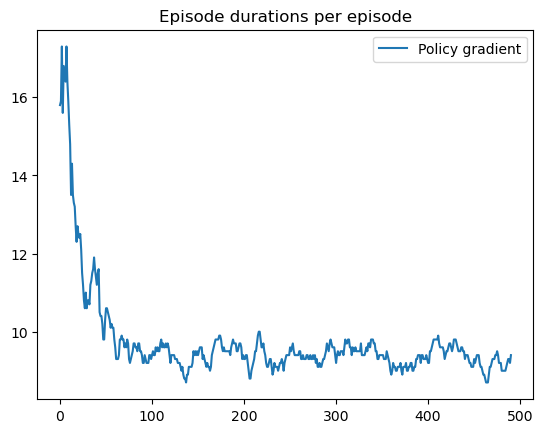

In [42]:
# Feel free to play around with the parameters!
num_episodes = 500
discount_factor = 0.99
learn_rate = 0.001
seed = 42
env = gym.envs.make("CartPole-v1")
torch.manual_seed(seed)
env.seed(seed)
policy = NNPolicy(num_hidden)

episode_durations_policy_gradient = run_episodes_policy_gradient(
    policy, env, num_episodes, discount_factor, learn_rate)

plt.plot(smooth(episode_durations_policy_gradient, 10))
plt.title('Episode durations per episode')
plt.legend(['Policy gradient'])

If you want to test/submit your solution **restart the kernel, run all cells and submit the pg_autograde.py file into codegrade.**